In [26]:
# CHAPTER 4 FINITE VOLUME METHOD FOR DIFFUSION PROBLEMS

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
Lx        = 0.02 # Length of the plate
num_nodes = 5
del_x     = Lx / num_nodes
k         = 0.5
A         = 0.01
A         = 1

q         = 1_000_000  # uniform heat generation

T_A       = 100
T_B       = 200

In [29]:
# We treat the first term of the above equation as in the previous example. The
# second integral, the source term of the equation, is evaluated by calculating
# the average generation (i.e. D∆V= q∆V) within each control volume.

In [30]:
node_lengths = [del_x] * num_nodes
node_lengths

[0.004, 0.004, 0.004, 0.004, 0.004]

In [31]:
half_length = [i/2 for i in node_lengths]
half_length

[0.002, 0.002, 0.002, 0.002, 0.002]

In [32]:
PE_WP = []
for i in range(len(half_length)):
    if i == 0:
        PE_WP.append([half_length[i], half_length[i] + half_length[i+1]])
    elif i == len(half_length)-1:
        PE_WP.append([half_length[i] + half_length[i-1], half_length[i]])
    else:
        PE_WP.append([half_length[i] + half_length[i-1], half_length[i] + half_length[i+1]])

In [33]:
PE_WP

[[0.002, 0.004],
 [0.004, 0.004],
 [0.004, 0.004],
 [0.004, 0.004],
 [0.004, 0.002]]

In [58]:
def coef_generator(k, del_PE, del_WP, idx):
    node_num = idx + 1

    if idx == 0:                         # Treating boundary's source term differently. eqn 4.36
        S_P = (-2 * k * A) / max(del_WP, del_PE)
        S_U = (q * A * max(del_WP, del_PE)) + ((2 * k * A * T_A) / max(del_WP, del_PE))
        aw  =  0
        ae  = ((k*A)/max(del_WP, del_PE))
        ap  = aw + ae - S_P

    elif idx == len(PE_WP)-1:            # Treating boundary's source term differently. eqn 4.36
        S_P = (-2 * k * A) / max(del_WP, del_PE)
        S_U = (q * A * max(del_WP, del_PE)) + ((2 * k * A * T_A) / max(del_WP, del_PE))
        aw  = ((k*A)/max(del_WP, del_PE))
        ae  = 0
        ap  = aw + ae - S_P
    
    else:                                # Treating non boundary's source term differently. eqn 4.33
        S_P = 0
        S_U = q * A * max(del_WP, del_PE)
        aw = ((k*A)/max(del_WP, del_PE))
        ae = ((k*A)/max(del_WP, del_PE))
        ap = aw + ae - S_P
        ap  += S_P

    return (ap, idx), (aw, idx - 1), (ae, idx + 1), S_U, S_P

coef_matrix = []
for del_distances_idx in range(len(PE_WP)):
    coef_matrix.append(coef_generator(
                            k,
                            del_PE = PE_WP[del_distances_idx][1],
                            del_WP = PE_WP[del_distances_idx][0],
                            idx    = del_distances_idx
                            )
                        )

In [59]:
coef_generator(
            k,
            del_PE = PE_WP[del_distances_idx][1],
            del_WP = PE_WP[del_distances_idx][0],
            idx    = 0
            )

((375.0, 0), (0, -1), (125.0, 1), 29000.0, -250.0)

In [60]:
coef_matrix

[((375.0, 0), (0, -1), (125.0, 1), 29000.0, -250.0),
 ((250.0, 1), (125.0, 0), (125.0, 2), 4000.0, 0),
 ((250.0, 2), (125.0, 1), (125.0, 3), 4000.0, 0),
 ((250.0, 3), (125.0, 2), (125.0, 4), 4000.0, 0),
 ((375.0, 4), (125.0, 3), (0, 5), 29000.0, -250.0)]

In [61]:
matrix_A = np.zeros((len(PE_WP), len(PE_WP)))
matrix_A

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [37]:
matrix_B = np.zeros((len(PE_WP)))
matrix_B

array([0., 0., 0., 0., 0.])

In [ ]:
matrix_A = np.zeros((len(PE_WP), len(PE_WP)))
matrix_B = np.zeros((len(PE_WP)))

for i_idx, i in enumerate(coef_matrix):
    for j_idx, j in enumerate(i):
        if type(j) == tuple:
            if j[1] == -1 :
                matrix_B[i_idx] = j[0] * T_A
            elif j[1] == len(PE_WP):
                matrix_B[i_idx] = j[0] * T_B
            else:
                if i_idx != j[1]:
                    matrix_A[i_idx][j[1]] = j[0] * -1
                else:
                    matrix_A[i_idx][j[1]] = j[0]

array([0., 0., 0., 0., 0.])

In [68]:
matrix_B = [i[-2] for i in coef_matrix]
matrix_B

[29000.0, 4000.0, 4000.0, 4000.0, 29000.0]

In [69]:
matrix_A

array([[ 375., -125.,    0.,    0.,    0.],
       [-125.,  250., -125.,    0.,    0.],
       [   0., -125.,  250., -125.,    0.],
       [   0.,    0., -125.,  250., -125.],
       [   0.,    0.,    0., -125.,  375.]])

In [70]:
X = np.zeros(len(matrix_B))

In [71]:
def Gauss_Sadel(A, B, X, tolerance):
    relative_error = np.inf
    loops_taken = 0

    while relative_error > tolerance:
        X_old = X.copy()
        for j in range(len(A)):
            sum = 0
            for i in range(len(A)):
                if i != j:
                    sum += A[j][i] * X[i]
            X[j] = (B[j] - sum) / A[j][j]

        relative_error = np.max(np.abs(X - X_old) / (np.abs(X) + 1e-9))
        loops_taken += 1

    return X, loops_taken
X, loops_taken = Gauss_Sadel(matrix_A, matrix_B, X, tolerance = 1e-12)

In [72]:
X

array([140., 188., 204., 188., 140.])

In [73]:
loops_taken

68

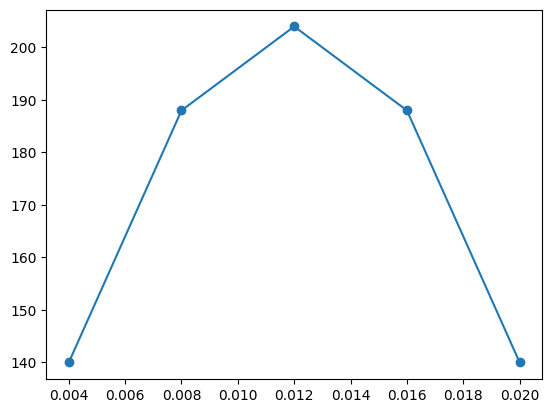

In [74]:
plt.plot(np.cumsum(node_lengths), X, marker='o')

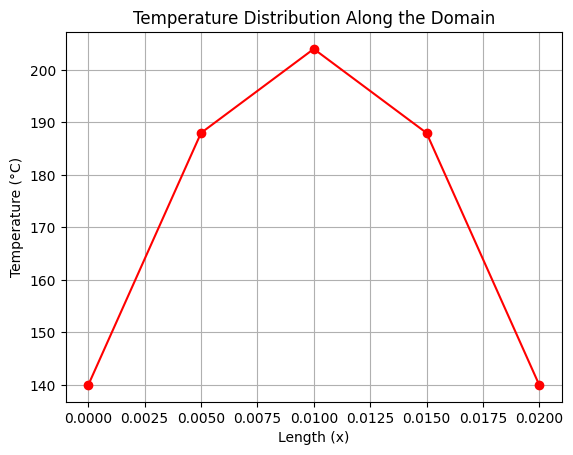

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose you have N nodes along x, and temperature vector X
N = len(X)
x = np.linspace(0, Lx, N)  # spatial positions along domain length L

plt.plot(x, X, marker='o', linestyle='-', color='red')
plt.xlabel('Length (x)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Distribution Along the Domain')
plt.grid(True)
plt.show()